#Symbolic Function Approximation with LSTM (from-scratch LSTM cell)

What this notebook does (high level):
1. Generate datasets: x -> f(x) for several functions (sin, tanh, exp, polynomial, composite).
2. Represent each scalar x as a small sequence of features (decimal digits + normalized magnitude) so an LSTM can treat it as sequence input.
3. Implement an LSTM cell manually in PyTorch (gates, hidden/cell state updates).
4. Build a small sequence-to-scalar network using the custom LSTM + MLP head.
5. Train the network to approximate f(x) for chosen functions and also to generalize across function families.
6. Visualize predictions vs true function; plot error curves.
7. Visualize hidden-layer activations across x (per neuron) and use PCA to compress activations for plotting.
8. Derive an approximate symbolic equation by fitting a linear combination of candidate basis functions (polynomial, trig, exp) to the network's predictions (linear regression) — yields an interpretable approximate formula.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


#Dataset Generation

In [3]:
def generate_functions():
  return {
  'sin': lambda x: np.sin(x),
  'tanh': lambda x: np.tanh(x),
  'exp': lambda x: np.exp(x),
  'poly3': lambda x: 0.5*x**3 - 0.2*x**2 + 0.1*x,
  'composite': lambda x: np.sin(x) + 0.2*np.exp(0.3*x)
  }

def scalar_to_digit_sequence(xs, seq_len=6, base=10, pad_front=True):
    sequences = []
    for x in xs:
      sign = 1.0 if x>=0 else -1.0
      ax = abs(x)
      int_part = int(math.floor(ax))
      frac = ax - int_part
      int_digits = []
      temp = int_part
      for _ in range(seq_len//2):
        int_digits.append(temp % base)
        temp //= base
      int_digits = list(reversed(int_digits))
      frac_digits = []
      f = frac
      for _ in range(seq_len - len(int_digits)):
        f *= base
        d = int(math.floor(f))
        frac_digits.append(d)
        f -= d
      digits = int_digits + frac_digits
      digit_feats = [d/(base-1) for d in digits]
      mag = np.tanh(ax/5.0)
      seq = []
      for dv in digit_feats:
        seq.append([dv, sign, mag])
      sequences.append(np.array(seq, dtype=np.float32))
    return np.stack(sequences)

In [4]:
class FunctionDataset(Dataset):
  def __init__(self, x, y):
   self.x = x.astype(np.float32)
   self.y = y.astype(np.float32)
  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]


In [5]:

funcs = generate_functions()

N_train = 2000
N_test = 800
x_train = np.random.uniform(-4, 4, size=(N_train,))
x_test = np.random.uniform(-6, 6, size=(N_test,))
target_name = 'composite'
f = funcs[target_name]


y_train = f(x_train)
y_test = f(x_test)


seq_len = 8
X_train_seq = scalar_to_digit_sequence(x_train, seq_len=seq_len)
X_test_seq = scalar_to_digit_sequence(x_test, seq_len=seq_len)


train_loader = DataLoader(FunctionDataset(X_train_seq, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(FunctionDataset(X_test_seq, y_test), batch_size=128, shuffle=False)


print('Shapes: ', X_train_seq.shape, y_train.shape)

Shapes:  (2000, 8, 3) (2000,)


In [7]:
class ManualLSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.linear = nn.Linear(input_size + hidden_size, 4*hidden_size)

  def forward(self, x_t, hidden):

    h_prev, c_prev = hidden
    combined = torch.cat([h_prev, x_t], dim=1)
    gates = self.linear(combined)
    i, f, g, o = gates.chunk(4, dim=1)
    i = torch.sigmoid(i)
    f = torch.sigmoid(f)
    o = torch.sigmoid(o)
    g = torch.tanh(g)
    c_next = f * c_prev + i * g
    h_next = o * torch.tanh(c_next)
    return h_next, c_next

In [8]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, fc_hidden=64, record_activations=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = ManualLSTMCell(input_size, hidden_size)
        self.fc = nn.Sequential(
        nn.Linear(hidden_size, fc_hidden),
        nn.ReLU(),
        nn.Linear(fc_hidden, 1)
        )
        self.record_activations = record_activations


    def forward(self, x):

      batch, seq_len, _ = x.size()
      h = torch.zeros(batch, self.hidden_size, device=x.device)
      c = torch.zeros(batch, self.hidden_size, device=x.device)
      activations = []
      for t in range(seq_len):
        h, c = self.cell(x[:, t, :], (h, c))
        if self.record_activations:
          activations.append(h.detach().cpu().numpy())
      out = self.fc(h).squeeze(1)
      if self.record_activations:
        activations = np.stack(activations, axis=1)
        return out, activations
      return out

In [10]:
def train_model(model, train_loader, val_loader, epochs=60, lr=1e-3):
  model.to(device)
  opt = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  history = {'train_loss':[], 'val_loss':[]}
  for ep in range(1, epochs+1):
    model.train()
    running = 0.0
    count = 0
    for xb, yb in train_loader:
      xb = xb.to(device)
      yb = yb.to(device)
      opt.zero_grad()
      preds = model(xb)
      loss = criterion(preds, yb)
      loss.backward()
      opt.step()
      running += loss.item() * xb.size(0)
      count += xb.size(0)
    train_loss = running / count
    model.eval()
    vrunning = 0.0
    vcount = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        vrunning += loss.item() * xb.size(0)
        vcount += xb.size(0)
    val_loss = vrunning / vcount
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if ep % 10 == 0 or ep == 1:
      print(f'Epoch {ep:03d} Train Loss: {train_loss:.6f} Val Loss: {val_loss:.6f}')
  return history

Epoch 001 Train Loss: 0.391192 Val Loss: 0.574875
Epoch 010 Train Loss: 0.001162 Val Loss: 0.077684
Epoch 020 Train Loss: 0.000115 Val Loss: 0.073483
Epoch 030 Train Loss: 0.000086 Val Loss: 0.068659
Epoch 040 Train Loss: 0.000021 Val Loss: 0.068824
Epoch 050 Train Loss: 0.000017 Val Loss: 0.069871
Epoch 060 Train Loss: 0.000224 Val Loss: 0.069608
Epoch 070 Train Loss: 0.000015 Val Loss: 0.075039
Epoch 080 Train Loss: 0.000013 Val Loss: 0.074531


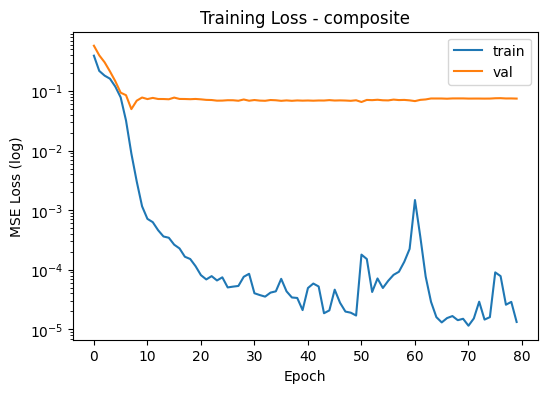

In [11]:
input_size = X_train_seq.shape[2]
hidden_size = 64
model = LSTMRegressor(input_size, hidden_size, record_activations=False)


history = train_model(model, train_loader, val_loader, epochs=80, lr=1e-3)


plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log)')
plt.legend()
plt.title(f'Training Loss - {target_name}')
plt.show()

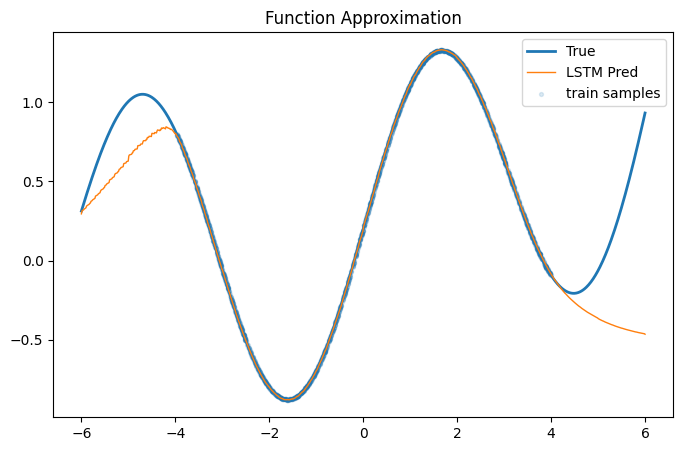

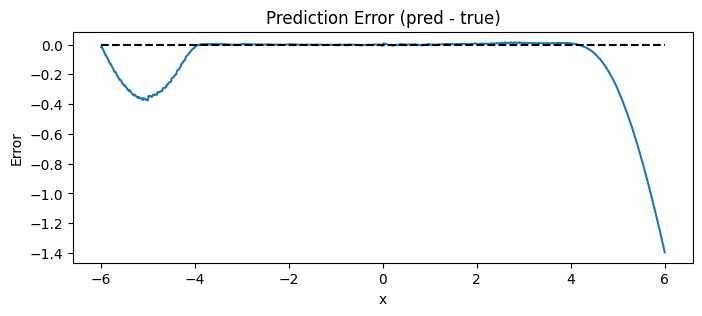

In [12]:
def predict_on_grid(model, x_grid):
    model.eval()
    Xg_seq = scalar_to_digit_sequence(x_grid, seq_len=seq_len)
    Xg = torch.tensor(Xg_seq, device=device)
    with torch.no_grad():
      preds = model(Xg).cpu().numpy()
    return preds


x_grid = np.linspace(-6, 6, 1000)
y_true = f(x_grid)
y_pred = predict_on_grid(model, x_grid)


plt.figure(figsize=(8,5))
plt.plot(x_grid, y_true, label='True', linewidth=2)
plt.plot(x_grid, y_pred, label='LSTM Pred', linewidth=1)
plt.scatter(x_train, y_train, s=8, alpha=0.15, label='train samples')
plt.legend()
plt.title('Function Approximation')
plt.show()

plt.figure(figsize=(8,3))
plt.plot(x_grid, y_pred - y_true)
plt.title('Prediction Error (pred - true)')
plt.xlabel('x')
plt.ylabel('Error')
plt.hlines(0, x_grid.min(), x_grid.max(), colors='k', linestyles='dashed')
plt.show()

Activations shape: (1000, 8, 64)


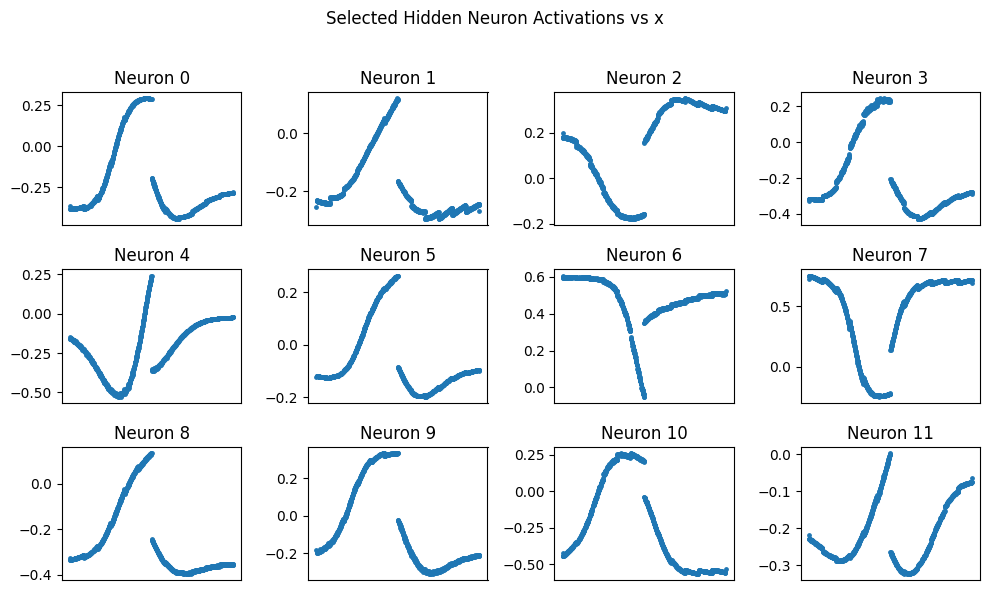

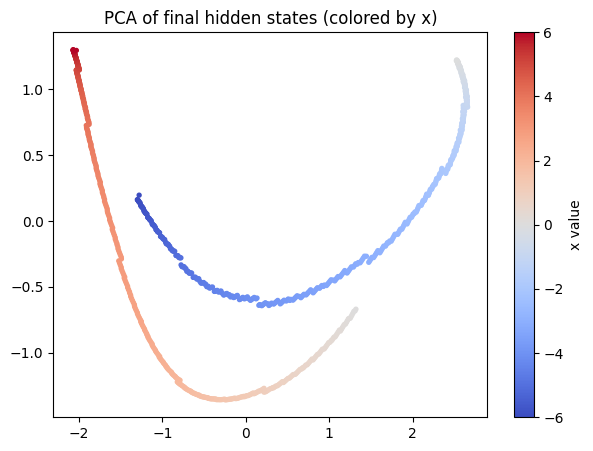

In [14]:
model_act = LSTMRegressor(input_size, hidden_size, record_activations=True).to(device)
model_act.load_state_dict(model.state_dict())
model_act.eval()

batch_size = 256
acts = []
for i in range(0, len(x_grid), batch_size):
  xb_seq = scalar_to_digit_sequence(x_grid[i:i+batch_size], seq_len=seq_len)
  xb = torch.tensor(xb_seq, device=device)
  with torch.no_grad():
    _, a = model_act(xb)
  acts.append(a)
acts = np.concatenate(acts, axis=0)
print('Activations shape:', acts.shape)

final_h = acts[:, -1, :]
plt.figure(figsize=(10,6))
neurons_to_plot = list(range(0, min(12, hidden_size)))
for i, n in enumerate(neurons_to_plot):
  plt.subplot(3,4,i+1)
  plt.scatter(x_grid, final_h[:, n], s=6)
  plt.title(f'Neuron {n}')
  plt.xticks([])
plt.suptitle('Selected Hidden Neuron Activations vs x')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

pca = PCA(n_components=2)
proj = pca.fit_transform(final_h)
plt.figure(figsize=(7,5))
plt.scatter(proj[:,0], proj[:,1], c=x_grid, cmap='coolwarm', s=8)
plt.colorbar(label='x value')
plt.title('PCA of final hidden states (colored by x)')
plt.show()

In [15]:
def build_basis(x):
# x: (N,)
  x = np.asarray(x)
  B = []
  for d in range(6):
    B.append(x**d)

  B.append(np.sin(x))
  B.append(np.cos(x))
  B.append(np.sin(2*x))
  B.append(np.cos(2*x))
  B.append(np.exp(0.2*x))
  B.append(np.exp(-0.2*x))
  B.append(np.tanh(x))
  return np.vstack(B).T


B = build_basis(x_grid)
reg = LinearRegression(fit_intercept=False)
reg.fit(B, y_pred)
coeffs = reg.coef_

Top basis function contributors (abs coeff, coeff, term):
6663.4676, 6663.4676, exp(0.2x)
5309.5077, -5309.5077, exp(-0.2x)
2395.3227, -2395.3227, x
1354.0627, -1354.0627, 1
26.9305, -26.9305, x^2
15.8758, -15.8758, x^3
1.3583, 1.3583, sin(x)
0.6184, 0.6184, tanh(x)

Approximate symbolic expression:
y ≈  + 6663.4676*exp(0.2x) - 5309.5077*exp(-0.2x) - 2395.3227*x - 1354.0627*1 - 26.9305*x^2 - 15.8758*x^3


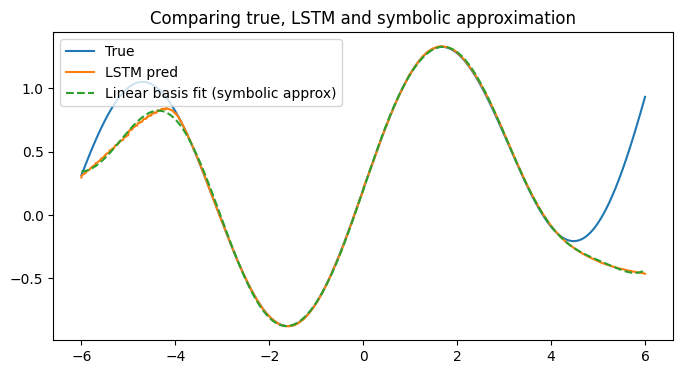

In [16]:
terms = ['1','x','x^2','x^3','x^4','x^5','sin(x)','cos(x)','sin(2x)','cos(2x)','exp(0.2x)','exp(-0.2x)','tanh(x)']
coef_term_pairs = sorted(zip(np.abs(coeffs), coeffs, terms), reverse=True)
print('Top basis function contributors (abs coeff, coeff, term):')
for a,c,t in coef_term_pairs[:8]:
  print(f'{a:.4f}, {c:.4f}, {t}')

top_k = 6
top = coef_term_pairs[:top_k]
expr = 'y ≈ '
for i, (_, c, t) in enumerate(top):
  sign = '+' if c>=0 else '-'
  expr += f' {sign} {abs(c):.4f}*{t}'
print('\nApproximate symbolic expression:')
print(expr)

y_sym = reg.predict(B)
plt.figure(figsize=(8,4))
plt.plot(x_grid, y_true, label='True')
plt.plot(x_grid, y_pred, label='LSTM pred')
plt.plot(x_grid, y_sym, '--', label='Linear basis fit (symbolic approx)')
plt.legend()
plt.title('Comparing true, LSTM and symbolic approximation')
plt.show()